In [179]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


In [180]:
file = '/Users/Fabio/Desktop/CMS-SpikingNeuralNetwork/Code/MODE/CSV/23.csv'
data_pd = pd.read_csv(file) #NEW WORKs
# data_pd = pd.read_csv("NL0=20_NL1=20_NCl=6_CF01=1.00_CFI0=1.00_CFI1=1.00_alfa=0.90_output.csv") #OLD WORKS
data_pd.describe()


,Event,ID,Stream,Time,Pclass
count,4823.000000,4823.000000,4823.000000,4.823000e+03,4823.000000
mean,99757.812565,1.109475,6.003939,6.449600e-07,2.348538
std,143.470132,0.312267,2.897850,3.555122e-07,1.678487
min,99501.000000,1.000000,0.000000,1.394630e-08,0.000000
25%,99635.000000,1.000000,4.000000,3.576700e-07,1.000000
50%,99758.000000,1.000000,6.000000,6.672200e-07,2.000000
75%,99884.000000,1.000000,8.000000,9.446220e-07,4.000000
max,99997.000000,2.000000,11.000000,1.242690e-06,5.000000


In [181]:
print(data_pd.keys())

Index(['Event', 'ID', 'Stream', 'Time', 'Pclass'], dtype='object')


Preprocess

In [182]:
data = dict()
for col in data_pd.columns:
    data[col] = data_pd[col].values

In [183]:
#moltiply data['Stream'] by -1 if it a track (data['id'] == 1)
data['Stream'] = np.where(data['ID'] == 1, -1*data['Stream'], data['Stream'])

Plots

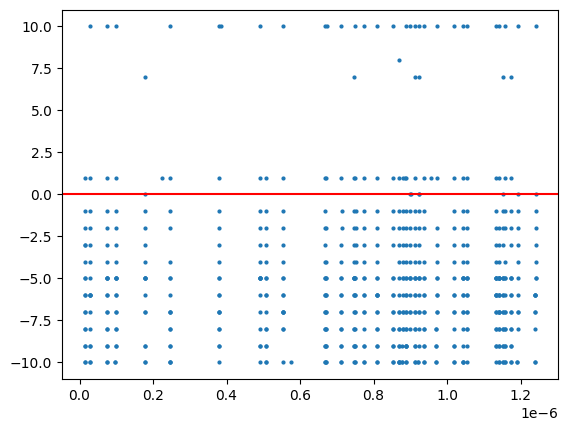

In [184]:
class_mask = data_pd['Pclass'] == 2
plt.scatter(data['Time'][class_mask], data['Stream'][class_mask] , s=4)
# plt.xlim(1e-7, 7.25e-7)
plt.axhline(0, c = 'r')

## Looking at one single event

In [185]:
N_EV = np.unique(data['Event'][data['Pclass'] == 5])[-11]
N_EV

99818

In [186]:
#select an event using data_dict['Event']
mask_ev1 = data['Event'] == N_EV

ev1 = {}
for k in data_pd.keys():
    ev1[k] = data[k][mask_ev1]


In [187]:
t_track = ev1['Time'][ev1['ID'] == 1]
t_neur = ev1['Time'][ev1['ID'] == 2]
t_neur

array([4.71155e-07, 4.71155e-07, 4.71155e-07])

In [188]:
ev1['Stream'][ev1['ID'] == 3]

array([], dtype=int64)

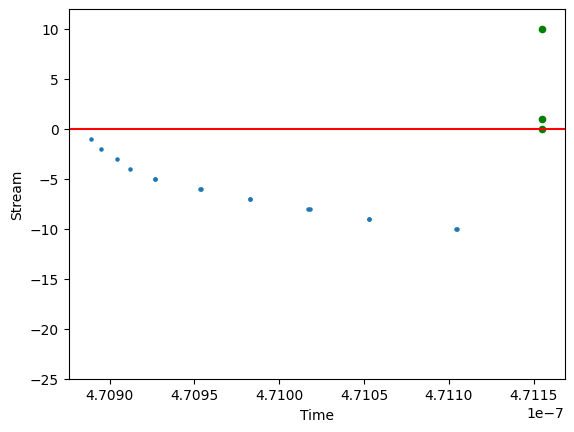

In [189]:
plt.scatter(t_track, ev1['Stream'][ev1['ID'] == 1], s=5)
plt.scatter(t_neur, ev1['Stream'][ev1['ID'] == 2], c='g', s = 20)
plt.ylim(-25,12)
plt.axhline(0, c = 'r')
plt.xlabel('Time')
plt.ylabel('Stream')
plt.show()
#plot the grid on x and y


In [190]:
hit_neur = ev1['Stream'][ev1['ID'] == 2]
hit_neur

array([10,  0,  1])

Every spike that arrives induces a change in the membrane potential according to a certain function.\
These changes are smoothed to zero after a time of 7 τ from the arrival of the impulse.\
So, when the neuron receives the last hit of the trace, after a time of 7 τ, the effect of that impulse on the membrane potential is automatically zero.

In [191]:
tau = 1e-9

In [192]:
min_t_track = np.min(t_track)- 7*tau
max_t_track = np.max(t_track)+ 7*tau

mask_sel_neur = np.logical_and(t_neur>min_t_track, t_neur<max_t_track)
mask_sel_neur

array([ True,  True,  True])

In [193]:
#Using min_t_track and max_t_track,let's bin in 10 bins the time interval and put the hits of neuron inside the bins
n_bins = 12
bins = np.arange(1, n_bins+1)

print(bins.shape)
print(bins)
hist_y, bin_edges_y = np.histogram(hit_neur[mask_sel_neur], bins=bins)
hist_y


(12,)
[ 1  2  3  4  5  6  7  8  9 10 11 12]


array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

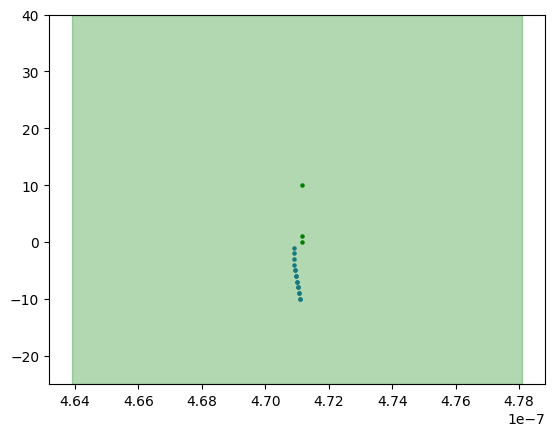

In [194]:
# now the same plt but with filled zoned in red where i excluded the points
plt.scatter(t_track, ev1['Stream'][ev1['ID'] == 1], s=5)
plt.scatter(t_neur[mask_sel_neur], hit_neur[mask_sel_neur], c='g', s = 5)
plt.ylim(-25,40)
plt.axvspan(min_t_track, max_t_track, alpha=0.3, color='green')

plt.show()

## For every event

In [195]:
def get_hist_neuron(N_EV, data, N_NEUR):

    """
    This function returns the histogram of the neuron hits inside the track of the particle
    """
    #select an event using data_dict['Event']
    mask_ev1 = data['Event'] == N_EV
    
    ev1 = {}

    for k in data.keys():
        ev1[k] = data[k][mask_ev1]

    t_track = ev1['Time'][ev1['ID'] == 1]

    t_neur = ev1['Time'][ev1['ID'] == 2]
    hit_neur = ev1['Stream'][ev1['ID'] == 2]

    min_t_track = np.min(t_track) - 0.01e-7
    max_t_track = np.max(t_track) + 0.01e-7
    mask_sel_neur = np.logical_and(t_neur>min_t_track, t_neur<max_t_track)

    bins = np.arange(0, N_NEUR+1)

    #now check if inside the t_neuron there are values inside the bins
    hist, bin_edges = np.histogram(hit_neur[mask_sel_neur], bins=bins)

    return hist


In [196]:
get_hist_neuron(N_EV, data, 12)

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [197]:
N_EV_class0 = np.unique(data['Event'][data['Pclass'] == 0])
N_EV_class1 = np.unique(data['Event'][data['Pclass'] == 1])
N_EV_class2 = np.unique(data['Event'][data['Pclass'] == 2])
N_EV_class3 = np.unique(data['Event'][data['Pclass'] == 3])
N_EV_class4 = np.unique(data['Event'][data['Pclass'] == 4])
N_EV_class5 = np.unique(data['Event'][data['Pclass'] == 5])

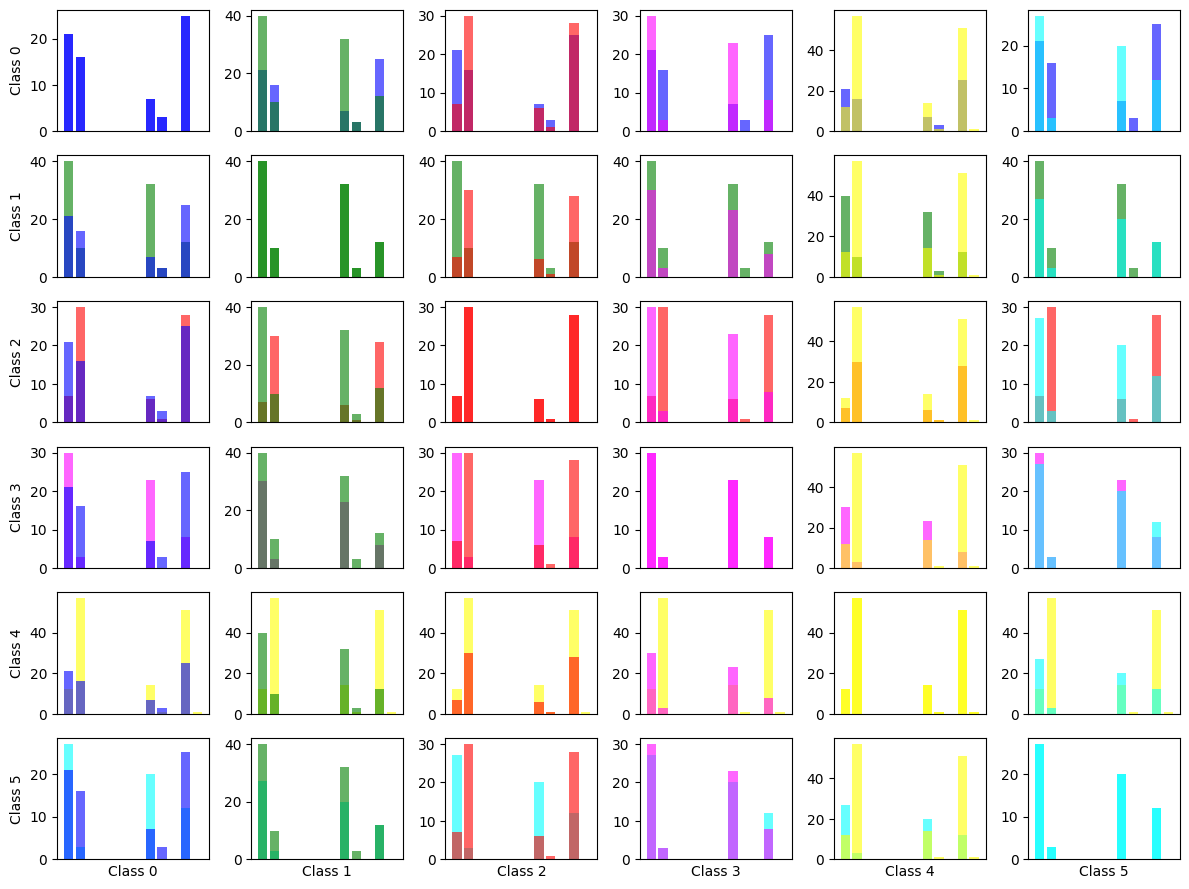

In [198]:
N_NEUR = 12 

hist0 = np.zeros(N_NEUR)
hist1 = np.zeros(N_NEUR)
hist2 = np.zeros(N_NEUR)
hist3 = np.zeros(N_NEUR)
hist4 = np.zeros(N_NEUR)
hist5 = np.zeros(N_NEUR)

H0 = []
H1 = []
H2 = []
H3 = []
H4 = []
H5 = []

for EV in N_EV_class0:
    hist0 = hist0 + get_hist_neuron(EV, data,N_NEUR)
    H0.append(get_hist_neuron(EV, data,N_NEUR))


for EV in N_EV_class1:
    hist1 = hist1 + get_hist_neuron(EV, data,N_NEUR)
    H1.append(get_hist_neuron(EV, data,N_NEUR))



for EV in N_EV_class2:
    hist2 = hist2 + get_hist_neuron(EV, data,N_NEUR)
    H2.append(get_hist_neuron(EV, data,N_NEUR))



for EV in N_EV_class3:
    hist3 = hist3 + get_hist_neuron(EV, data,N_NEUR)
    H3.append(get_hist_neuron(EV, data,N_NEUR))




for EV in N_EV_class4:
    hist4 = hist4 + get_hist_neuron(EV, data,N_NEUR)
    H4.append(get_hist_neuron(EV, data,N_NEUR))



for EV in N_EV_class5:
    hist5 = hist5 + get_hist_neuron(EV, data,N_NEUR)
    H5.append(get_hist_neuron(EV, data,N_NEUR))


HISTS = [hist0, hist1, hist2, hist3, hist4, hist5]
HISTS = np.array(HISTS)

COLORS = ['b', 'g', 'r', 'magenta', 'yellow', 'cyan']

#Now create a matrix plot comparing hist_i and hist_j
plt.subplots(6,6, figsize=(12,9))
for i in range(6):
    for j in range(6):
        plt.subplot(6,6,6*i+j+1)
        plt.bar(np.arange(len(HISTS[i])),HISTS[i], color = COLORS[i], alpha = 0.6)
        plt.bar(np.arange(len(HISTS[j])),HISTS[j], color = COLORS[j], alpha = 0.6)
        plt.xticks([])

        #I want the labels only on the right and on the top
        if j == 0:
            plt.ylabel('Class {}'.format(i))
        if i == 5:
            plt.xlabel('Class {}'.format(j))
        #plot the axes on every histo

            

plt.tight_layout()

In [199]:
H = H0 + H1 + H2 + H3 + H4 + H5

label = []
for i in range(len(H0)):
    label.append(0)
for i in range(len(H1)):
    label.append(1)
for i in range(len(H2)):
    label.append(2)
for i in range(len(H3)):
    label.append(3)
for i in range(len(H4)):
    label.append(4)
for i in range(len(H5)):
    label.append(5)

label = np.array(label)
